## **************************************************************Feature Engineering**************************************************************

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import re
import zipfile
import requests
from bs4 import BeautifulSoup
from collections import Counter
import itertools

import spacy
from spacy.tokenizer import Tokenizer
import gensim as gen
from gensim.models import Word2Vec
from nltk.corpus import brown
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('brown')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import featuretools as ft
import featuretools.variable_types as vtypes
from featuretools.primitives import  AggregationPrimitive
from nlp_primitives import (
    DiversityScore,
    LSA,
    MeanCharactersPerWord,
    PolarityScore, 
    UniversalSentenceEncoder,
    PunctuationCount,
    StopwordCount,
    TitleWordCount,
    UpperCaseCount)

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 85% !important; }</style>"))

## Missing Packages Installation:

In [7]:
!pip install nlp_primitives
!pip install bs4
!pip install spacy
!pip install gensim
!pip install nltk
!pip install seaborn
! python -m spacy download en

## Google Drive Mounting (When executed in google colab):

In [8]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

## Configuration Variables

In [11]:
AMBIGUOUS_WORDS_URL = 'https://muse.dillfrog.com/lists/ambiguous'
path = ""

## Load Dataset:

In [12]:
df = pd.read_pickle(path+'eda_reddit_jokes.pkl')

In [14]:
df.head()

joke  score
0  I hate how you cant even say black paint anymo...      1
1  Brian raises his hand and says, “He’s in Heave...      1
2  I walked into a PETA adoption center and the r...      1
3  Remember when you were a kid and when you crie...     15
4  My boss said to me, "you're the worst train dr...      3

## Outliers Removal

#### Long Jokes Removal

In [15]:
df['joke_words'] = df['joke'].apply(lambda x: len(x.split(' ')))

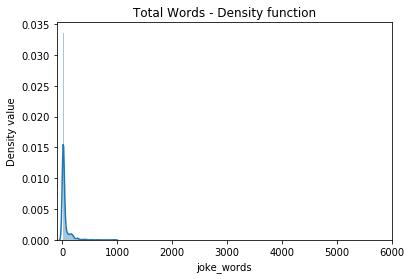

In [16]:
# Feature scaling and outliers removal
# f = plt.figure(figsize=(20,10))
ax = sns.distplot(df[df['joke_words']< 1000]['joke_words']);
ax.set_title('Total Words - Density function');
ax.set_ylabel('Density value');
ax.set_xticks(np.arange(0,7000,1000))
plt.show();

In [17]:
df = df[df['joke_words']<=40].reset_index()
del df['index']
del df['joke_words']

## Load Spacy English Model

In [19]:
nlp = spacy.load('en')
def en_tokenize(string):
    return nlp(string)

## Generate new features

 #### Ambiguous words counter:

- Counting occurrences of ambiguous words

In [21]:
def get_ambiguous_words():
  res = requests.get(AMBIGUOUS_WORDS_URL)
  page_soup = BeautifulSoup(res.content)
  a_tags = page_soup.find_all('a', href=re.compile(r'.*/meaning/word/*'))
  ambiguous_words = [word.text for word in a_tags]
  return ambiguous_words

In [2]:
ambiguous_words = get_ambiguous_words()
df['ambiguous_words'] = df['joke'].apply(lambda x: sum([str(w) in ambiguous_words for w in x]))

#### Repetition

- Finding the best similarity score between two words in a joke 
- Based on Brown corpus embeddings

In [23]:
df['joke_tokenized'] = df['joke'].apply(nlp)
token_pos = df['joke_tokenized'].apply(lambda x: [(elm.text, elm.pos_) for elm in x])

In [3]:
b = Word2Vec(brown.sents())

def find_best_similarity(string):
    """ find the max similarity between two words """
    # unique words:
    word_list = list(set([word_pos[0] for word_pos in string if word_pos[1] != "PROPN"]))
    all_combi = list(itertools.combinations(word_list, 2))

    max_similarity = 0
    for pairs in all_combi:
        try:
            temp_similatity = b.similarity(pairs[0], pairs[1])
            if temp_similatity > max_similarity:
                max_similarity = temp_similatity
        except:
            pass # don't found the word in word2vec
    return max_similarity

In [4]:
df['best_score_similarity_words'] = token_pos.apply(find_best_similarity)

#### Antonym

- Counting the amount of Antonyms in a joke

In [28]:
list_of_antonyms=[]
from nltk.corpus import wordnet as wn
for i in wn.all_synsets():
    if i.pos() in ['a', 's']: 
        for j in i.lemmas(): 
            if j.antonyms(): 
                (j.name(), j.antonyms()[0].name()) and list_of_antonyms.append((j.name(), j.antonyms()[0].name()))
dict_antonyms = dict((y, x) for x, y in list_of_antonyms)

def find_antonyms(tokens_poss):
    """ count how many antonyms in sentence """
    word_list = [word_pos[0] for word_pos in tokens_poss]
    count = 0
    for word in word_list:
        try:
            if word in dict_antonyms:
                if dict_antonyms[word] in word_list:
                    count += 1
        except Exception:
            pass # don't found in dict
    return count


In [29]:
df['antonyms'] = token_pos.apply(find_antonyms)

#### Longest word

In [31]:
def len_longest_word(tokens_poss):
    """ check the length of the longest word """
    word_len_list = [(word_pos[0], len(word_pos[0]))  for word_pos in tokens_poss]
    word_len_list = sorted(word_len_list, key=lambda x: x[1])

    return word_len_list[-1][1]

In [32]:
df['longest_word'] = token_pos.apply(len_longest_word)

#### Special characters counter

In [34]:
def count_speical_chars(tokens_poss):
    """ how many speical chars in string """
    bin_isalphanumberic_list = [not word_pos[0].isalnum() for word_pos in tokens_poss]

    return np.sum(bin_isalphanumberic_list)

In [35]:
df['speical_chars'] = token_pos.apply(count_speical_chars)

#### Generate additional features using 'featuretools' package

**DiversityScore**
- Calculates the overall complexity of the text based on the total

**LSA**
- Calculates the Latent Semantic Analysis Values of Text Input

**MeanCharactersPerWord**
- Determines the mean number of characters per word.

**PolarityScore**
- Calculates the polarity of a text on a scale from -1 (negative) to 1 (positive)

**PunctuationCount**
- Determines number of punctuation characters in a string.

**StopwordCount**
- Determines number of stopwords in a string.

**TitleWordCount**
- Determines the number of title words in a string.

**UpperCaseCount**
- Calculates the number of upper case letters in text.


In [5]:
es = ft.EntitySet("jokes_df")
es.entity_from_dataframe(entity_id="jokes_df",
                          index="joke_id",
                          make_index=True,
                          dataframe=df)

In [38]:
"""
DiversityScore()
Calculates the overall complexity of the text based on the total

LSA()
Calculates the Latent Semantic Analysis Values of Text Input

MeanCharactersPerWord()
Determines the mean number of characters per word.

PolarityScore()
Calculates the polarity of a text on a scale from -1 (negative) to 1 (positive)

PunctuationCount()
Determines number of punctuation characters in a string.

StopwordCount()
Determines number of stopwords in a string.

TitleWordCount()
Determines the number of title words in a string.

UpperCaseCount()
Calculates the number of upper case letters in text.
"""

trans = [
#     DiversityScore,
#          LSA,
         MeanCharactersPerWord,
         UniversalSentenceEncoder,
         PolarityScore, 
         PunctuationCount,
         StopwordCount,
         TitleWordCount,
         UpperCaseCount]

#### Sentence Embeddings

In [6]:
feature_matrix_customers, features_defs = ft.dfs(entityset=es,
                  target_entity='jokes_df',
                #   instance_ids=["joke"],
                  trans_primitives=trans,
                  max_depth=4)

In [95]:
print(f'Number of features to add: {len(features_defs)}')

Number of features to add: 14


In [96]:
df = pd.concat([df['joke'],feature_matrix_customers], axis=1)

#### Object counter features

In [100]:
def add_object_count_cols(df,tokenized_col):
  df['temp'] = df[tokenized_col].apply(lambda x: [ent.label_ for ent in x.ents])
  mlb = MultiLabelBinarizer()
  mlb.fit(df['temp'])
  df = df.join(pd.DataFrame(mlb.transform(df['temp']),
                            columns=mlb.classes_,
                            index=df.index))
  del df['temp']
  return df


In [102]:
df = add_object_count_cols(df,'joke_tokenized')

#### Part-of-Speech features

In [104]:
def add_pos_count_cols(df,tokenized_col):
  df['temp'] = df[tokenized_col].apply(lambda x: [ent.pos_ for ent in x])
  mlb = MultiLabelBinarizer()
  mlb.fit(df['temp'])
  df = df.join(pd.DataFrame(mlb.transform(df['temp']),
                            columns=mlb.classes_,
                            index=df.index))
  del df['temp']
  return df

In [105]:
df = add_pos_count_cols(df,'joke_tokenized')

## Text pre-processing

#### Replacing Non-English punctuation

In [107]:
def replace_non_eng_punct(txt):
    return re.sub(r'/[^a-zA-Z0-9\s,.?!]/','*',txt).strip()

#### Replacing Escape Characters

In [108]:
def replace_escape(txt):
    updated_txt = re.sub(r'\n|\t|&amp;',' ',txt)
    return updated_txt.strip()

#### Removing Multi-Spaces

In [109]:
def remove_multi_spaces(txt):
    return re.sub(' +', ' ',txt)

#### Additional Cleaning and Pre-Processing

In [110]:
def preprocess_text(document):
  #         # Remove all the special characters
  document = re.sub(r'\W', ' ', str(document))

  #         # remove all single characters
  document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

  #         # Remove single characters from the start
  document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

  # Substituting multiple spaces with single space
  document = re.sub(r'\s+', ' ', document, flags=re.I)

  # Removing prefixed 'b'
  document = re.sub(r'^b\s+', '', document)

  # Converting to Lowercase
  document = document.lower()

  return document

In [111]:
df['joke_text_processed'] = df['joke'].apply(replace_non_eng_punct).apply(remove_multi_spaces).apply(replace_escape)

In [112]:
df['joke_text_processed'] = df['joke_text_processed'].apply(preprocess_text)

In [113]:
df['joke_processed_tokenized'] = df['joke_text_processed'].apply(nlp)

#### Lemmatization

In [115]:
stemmer = WordNetLemmatizer()
stop_words = stopwords.words('english')
lemmatize_remove_stop_words = lambda x: nlp(' '.join([stemmer.lemmatize(str(word)) for word in x if str(word) not in stop_words]))
lemmatize_remove_stop_words_str = lambda x: ' '.join([stemmer.lemmatize(str(word)) for word in x if str(word) not in stop_words])

In [116]:
df['joke_processed_tokenized_stemmed'] = df['joke_processed_tokenized'].apply(lemmatize_remove_stop_words)
df['joke_processed_tokenized_stemmed_str'] = df['joke_processed_tokenized'].apply(lemmatize_remove_stop_words_str)

### Total words / Total chars features

In [119]:
df['total_words'] = df['joke_tokenized'].apply(len)
df['total_chars'] = df['joke'].apply(len)

## Train/Test split:

In [120]:
target = 'score'
X = df[df.columns[df.columns!=target]]
y = df[target]

In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
y_train = y_train.reset_index()['score']
y_test = y_test.reset_index()['score']

In [123]:
X_train = X_train.loc[:,X_train.columns != 'index']
X_test = X_test.loc[:,X_test.columns != 'index']

## Adding TF/IDF Features

In [124]:
vectorizer = TfidfVectorizer(input='content', decode_error='strict', lowercase=True, stop_words='english', ngram_range=(1, 2), 
                max_features=1000, binary=True)

In [125]:
vectorizer.fit(X_train['joke_processed_tokenized_stemmed_str'])
tfidf_vec_train = vectorizer.transform(X_train['joke_processed_tokenized_stemmed_str']).toarray()
tfidf_vec_test = vectorizer.transform(X_test['joke_processed_tokenized_stemmed_str']).toarray()

In [126]:
X_train = X_train.merge(pd.DataFrame(tfidf_vec_train,columns=vectorizer.vocabulary_),how='left',left_index=True,right_index=True)
X_test = X_test.merge(pd.DataFrame(tfidf_vec_test,columns=vectorizer.vocabulary_),how='left',left_index=True,right_index=True)

## Check for missing data

In [127]:
def check_missing_data(df):
  """ 
      params: dataframe
      return: data of missing values, if have some.
  """
  flag=df.isna().sum().any()
  if flag==True:
      total = df.isnull().sum()
      percent = (df.isnull().sum())*100/(df.isnull().count())
      output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
      data_type = []
      for col in df.columns:
          dtype = str(df[col].dtype)
          data_type.append(dtype)
      output['Types'] = data_type
      return(output[output['Percent'] > 0].sort_values(by='Percent', ascending=False))
  else:
      return(False)

In [128]:
check_missing_data(X_train)

False

In [129]:
check_missing_data(X_test)

False

## Dump output to pickle:

In [130]:
pd.to_pickle(X_train, path + "X_train.pkl")
pd.to_pickle(X_test, path + "X_test.pkl")
pd.to_pickle(y_train, path + "y_train.pkl")
pd.to_pickle(y_test, path + "y_test.pkl")